# :computer: Check Database

In [31]:
import sqlalchemy 
import pandas as pd
import pathlib
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [32]:
db_path=pathlib.Path.cwd() / "bourbon/buffalo_trace.db"
db_path.exists()

True

In [33]:
engine = sqlalchemy.create_engine(f"sqlite:///{db_path.absolute()}")
# test connection 
with engine.connect() as conn: 
    with conn.begin(): 
        ver_no = conn.execute(sqlalchemy.text("SELECT SQLITE_VERSION()" )).fetchone()[0]
        print(f"Connected at SQLite V{ver_no}")

Connected at SQLite V3.35.5


In [34]:
inspect = sqlalchemy.inspect(engine)
inspect.get_table_names()

['buffalo_trace', 'product_avail', 'product_ext']

In [53]:
with engine.connect() as conn: 
    with conn.begin(): 
        sub_bourbon = pd.read_sql("select product_title, product_avail, product_update_time from buffalo_trace", engine)
 

# bourbon_data[["product_title","product_avail"]].plot(kind='line', legend=True)
print(f"duplicates: {len(sub_bourbon.index) - len((sub_bourbon.drop_duplicates()).index)}")
my_dupes = sub_bourbon[sub_bourbon.duplicated()]

duplicates: 0


In [54]:
de_duped = sub_bourbon.drop_duplicates()

In [55]:
bourbon_data = pd.read_sql("select * FROM buffalo_trace", engine)
today_bourbon = bourbon_data\
    .loc[pd.to_datetime(bourbon_data['product_update_time']).dt.date == dt.date.today() ,:]\
        .reset_index(drop=True)

bourbon_data.head()

,index,product_title,product_update_time,product_avail,data_update_time
0,0,Buffalo Trace,2023-08-13 13:20:00.000000,1,2023-08-14 00:11:04.168636
1,1,W.L. Weller Special Reserve,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
2,2,E.H. Taylor Jr. Small Batch,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
3,3,Eagle Rare,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
4,4,Blanton’s Single Barrel,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636


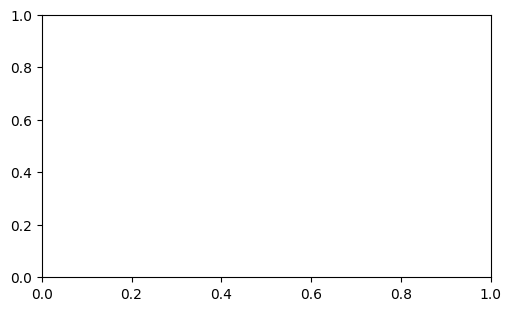

In [30]:
fig, ax = plt.subplots(figsize=(5,3),layout='constrained')
plt.plot(, label='blantons')  # Plot some data on the (implicit) axes.


In [ ]:
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(x, x, label='linear')  # Plot some data on the axes.
ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
ax.plot(x, x**3, label='cubic')  # ... and some more.
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

## Clean Duplicates

In [13]:
# clean dupes
print(f"deduped : {len(bourbon_data.drop_duplicates().index)}")
print(f"deduped : {len(bourbon_data.drop_duplicates(subset=['product_title','product_avail','product_update_time']).index)}")
print(f"normal : {len(bourbon_data.index)}")

deduped : 1855
deduped : 105
normal : 1855


In [50]:
de_duped = bourbon_data\
    .drop_duplicates(subset=[
        'product_title',
        'product_avail',
        'product_update_time'
    ]).reset_index(drop=True)

de_duped.drop(['level_0','index'], axis='columns',inplace=True)
de_duped

,product_title,product_update_time,product_avail,data_update_time
0,Buffalo Trace,2023-08-13 13:20:00.000000,1,2023-08-14 00:11:04.168636
1,W.L. Weller Special Reserve,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
2,E.H. Taylor Jr. Small Batch,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
3,Eagle Rare,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
4,Blanton’s Single Barrel,2023-08-13 13:20:00.000000,0,2023-08-14 00:11:04.168636
...,...,...,...,...
116,Eagle Rare,2023-08-22 09:00:00.000000,0,2023-08-22 13:12:10.263485
117,Blanton’s Single Barrel,2023-08-22 09:00:00.000000,0,2023-08-22 13:12:10.263485
118,Sazerac Rye,2023-08-22 09:00:00.000000,1,2023-08-22 13:12:10.263485
119,Wheatley,2023-08-22 09:00:00.000000,1,2023-08-22 13:12:10.263485


In [51]:
write_sql = True
if write_sql: 
    de_duped.to_sql(name='buffalo_trace', con=engine, if_exists='replace')